<a href="https://colab.research.google.com/github/wyngary/Lane-Car-Detector/blob/master/EECS504_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# EECS504 Project - Sign Language MNIST Classifer

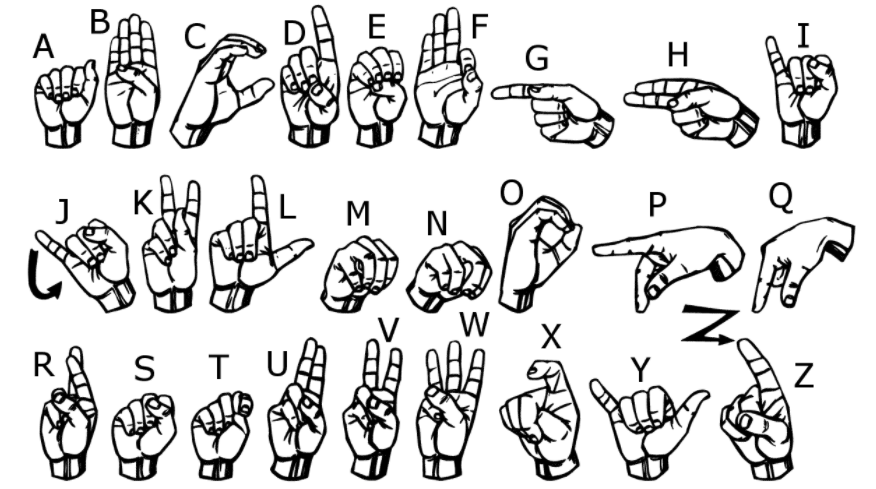

# Data Pre-analysis


In [12]:
# Initialization 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer



In [2]:
# Install Dataset
!pip install kaggle

import json
token = {"username":"wyngary","key":"0ef76215c761c0ed06495e34c5239d68"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle datasets download -d datamunge/sign-language-mnist -p /content
!unzip \*.zip

- path is now set to: /content
sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sign-language-mnist.zip
replace amer_sign2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [13]:
Raw_train = pd.read_csv('sign_mnist_train.csv')
Raw_test = pd.read_csv('sign_mnist_test.csv')
#df_tr.head()

X_tr = Raw_train.iloc[:,1:].values
Y_tr = Raw_train[['label']].values

X_train, X_vali, Y_train, Y_vali = train_test_split(X_tr, Y_tr, test_size=0.2)

X_train = (X_train - 128)/255
X_vali = (X_vali - 128)/255

X_test = Raw_test.iloc[:,1:].values
X_test = (X_test - 128)/255

Y_test = Raw_test[['label']].values


In [14]:
X_train_ = X_train.reshape(-1,28,28,1) 
Y_train_ = Y_train.reshape(-1,1) 

X_vali_ = X_vali.reshape(-1,28,28,1)
Y_vali_ = Y_vali.reshape(-1,1)

X_test_ = X_test.reshape(-1, 28, 28, 1)

In [15]:
lb=LabelBinarizer()
Y_train= lb.fit_transform(Y_train)
Y_vali= lb.fit_transform(Y_vali)
Y_test= lb.fit_transform(Y_test)

# Model

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  


datagen.fit(X_train_)

In [18]:

from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Convolutional network 
model = keras.Sequential()

model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', input_shape=(28, 28, 1)))
#model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'))

model.add(keras.layers.Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'))
#model.add(keras.layers.Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

#model.add(keras.layers.Conv2D(filters=128, kernel_size=2, strides=1, activation='relu'))
#model.add(keras.layers.Conv2D(filters=128, kernel_size=2, strides=1, activation='relu'))
#model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(Dropout(0.2))

model.add(keras.layers.Conv2D(filters=256, kernel_size=2, strides=1, activation='relu'))
#model.add(keras.layers.Conv2D(filters=256, kernel_size=2, strides=1, activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512,activation='relu'))
model.add(Dropout(0.25))

#model.add(keras.layers.Dense(256,activation='relu'))

model.add(keras.layers.Dense(24, activation='softmax'))

print(model.summary())

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])


early_stopping = [EarlyStopping(patience=3, monitor='val_loss'), ReduceLROnPlateau(patience=2), 
                  ModelCheckpoint(filepath='ASL_MNIST_CNN_temp.h5', save_best_only=True)]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 256)       65792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)             

# Training

In [19]:
history = model.fit(datagen.flow(X_train_, Y_train, batch_size = 250), epochs = 5, validation_data = (X_vali_, Y_vali) , callbacks = early_stopping)

model.save('ASL_MNIST_CNN.h5') # Saves architecture and weights
print('Model Saved')

Epoch 1/5
88/88 [==============================] - 68s 775ms/step - loss: 2.0412 - acc: 0.3776 - val_loss: 0.5539 - val_acc: 0.8463
Epoch 2/5
88/88 [==============================] - 68s 773ms/step - loss: 0.7773 - acc: 0.7465 - val_loss: 0.1690 - val_acc: 0.9547
Epoch 3/5
88/88 [==============================] - 68s 777ms/step - loss: 0.3907 - acc: 0.8742 - val_loss: 0.0629 - val_acc: 0.9871
Epoch 4/5
88/88 [==============================] - 68s 770ms/step - loss: 0.2520 - acc: 0.9154 - val_loss: 0.0329 - val_acc: 0.9940
Epoch 5/5
88/88 [==============================] - 68s 776ms/step - loss: 0.1760 - acc: 0.9411 - val_loss: 0.0111 - val_acc: 0.9989
Model Saved


In [21]:
test_loss, test_acurracy = model.evaluate(X_test_, Y_test)
print('Test loss: {:.2f}, accuracy: {:.2f}%'.format(test_loss, test_acurracy*100))

225/225 [==============================] - 7s 29ms/step - loss: 0.0452 - acc: 0.9852
Test loss: 0.05, accuracy: 98.52%


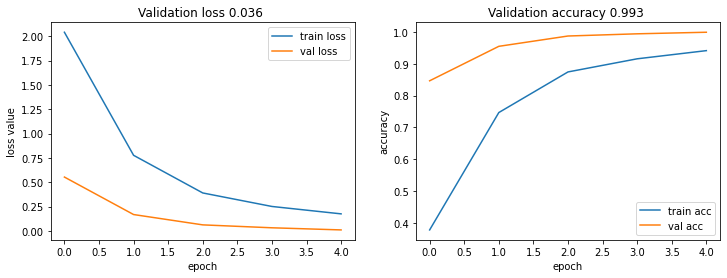

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} '.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['acc'], label='train acc')
ax2.plot(history.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} '.format(
    np.mean(history.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()